# 집값 예측 경진대회

## 패키지 import 및 데이터 전처리

In [583]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1328]:
df = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/train.csv')
test = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/test.csv')

In [1109]:
df.head()

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


`-` id는 필요없으니 제거

In [1329]:
df.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)

`-` 결측치는 없다

`-` 분석의 편의를 위해 컬럼명을 바꾸겠다

In [1330]:
## 공백과 슬래쉬를 _로 대체 1을 숫자가 아닌 다른 문자로 바꿈 

df.rename(columns = dict(zip(df.columns, [column.replace(' ', '_').replace('/', '_').replace('1', 'fir') for column in df.columns])), inplace = True) 
test.rename(columns = dict(zip(test.columns, [column.replace(' ', '_').replace('/', '_').replace('1', 'fir') for column in test.columns])), inplace = True) 

`-` 범주형 변수는 Exter Qual(외관 재료 품질;4개), Kitchen Qual(부엌 품질; 4개), Bsmt Qual(지하실 높이;5개)이다

`-` 총 5개의 등급이 존재하는데 Poor 등급은 Bsmt Qual에 1개 존재한다(나머지는 0개)

`-` 아예 poor등급이 존재하지 않는걸 수 도 있고 poor등급이 존재하는데 poor등급에 해당하는 건물이 존재하지 않는걸 수 도 있다

`-` 편의상 후자라고 생각하자

`-` 이들은 순서형 변수이므로 라벨 인코딩을 해주자

`-` 좋은 등급이 큰 값을 가지도록 하기위해 라벨인코딩을 정의해주자

In [1112]:
def label_encoding(data):
    grade_label = ['Po', 'Fa', 'TA', 'Gd', 'Ex'] ## 0~4점
    
    for grade, label in enumerate(grade_label):
        if data == label:
            return grade

In [1113]:
for col in df.columns[df.dtypes == 'object']:
    df[col] = df[col].apply(lambda x: label_encoding(x))

In [1114]:
df.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,first_Flr_SF,Bsmt_Qual,Full_Bath,Year_Built,Year_Remod_Add,Garage_Yr_Blt,target
0,10,2392,4,3,968,4,2392,2392,4,2,2003,2003,2003,386250
1,7,1352,3,2,466,3,1352,1352,4,2,2006,2007,2006,194000
2,5,900,2,1,288,2,864,900,2,1,1967,1967,1967,123000
3,5,1174,2,2,576,3,680,680,2,1,1900,2006,2000,135000
4,7,1958,3,3,936,3,1026,1026,3,2,2005,2005,2005,250000


`-` 라벨 인코딩이 잘 되었다

`-` 앞서 EDA에서 집값(target)이 오른쪽으로 꼬리가 긴 분포임을 확인했다

`-` 정규분포로 맞춰주기 위해 로그변환을 하자

In [1115]:
import scipy.stats as stats

<AxesSubplot:>

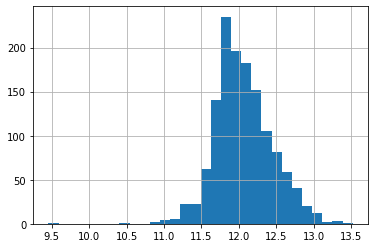

In [1116]:
np.log(df['target']).hist(bins = 30)

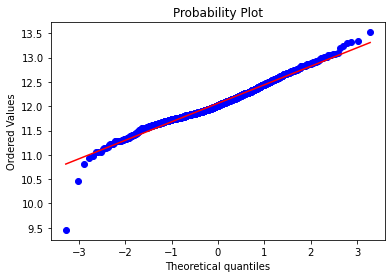

In [1117]:
_ = stats.probplot(np.log(df['target']), plot = plt)

`-` 로그 변환을 했지만 정규분포를 따르지 않는것처럼 보인다

`-` 샤피로-윌크 검정을 통해 정확히 확인하자

In [1118]:
test_stat, p_val = stats.shapiro(np.log(df['target']))

In [1119]:
p_val, np.log(df['target']).skew() ## p값과 왜도

(4.748497602069524e-13, 0.08070163740417918)

`-` 안타깝게도 정규분포를 따르지 않는다

`-` 왜도는 $0.08$로 거의 $0$

`-` 그런데 Q-Q플랏을 보면 심각한 이상치가 보인다(-3부근에 2개)

`-` 저런 이상치를 예측하는 것은 불가능해보이니 제거하자

`-` 값이 큰쪽으로도 이상점이 있는데 제거할지 말지 고민중이다

`-` 가장 비싼 집이 745000 달러인데 Gr_Liv_Area(지상층 생활 면적)이 4476으로 매우 넓다!

`-` 근데 생각해보니 제거하는 것이 맞는 것 같다(심각한 이상치로 인해 큰 영향을 끼칠 수 있음)

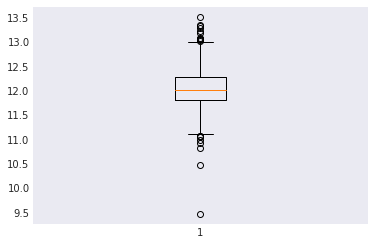

In [1120]:
with plt.style.context('seaborn-dark'): 
    plt.boxplot(np.log(df['target']))
plt.show()

`-` 로그 변환을 해서 나온 이상치들을 제거하자

In [1133]:
def remove_outlier(df):
    Q1 = np.log(df).quantile(0.25)
    Q3 = np.log(df).quantile(0.75)
    IQR = Q3 - Q1   

    filter_ = (np.log(df) >= Q1 - 1.5*IQR) & (np.log(df) <= Q3 + 1.5*IQR)
    return filter_

`-` df의 이상점을 제거한 df2를 만듦

In [1134]:
df2 = df.copy()

In [1135]:
df2 = df2[remove_outlier(np.log(df2['target']))]

<AxesSubplot:>

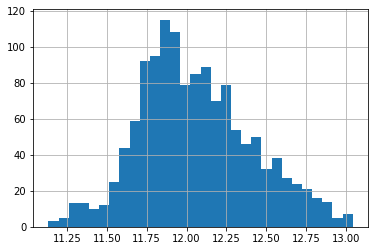

In [1136]:
np.log(df2['target']).hist(bins = 30)

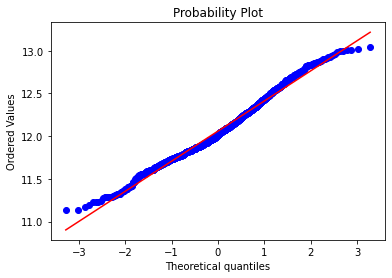

In [1155]:
_ = stats.probplot(np.log(df2['target']), plot = plt)

In [1152]:
test_stat, p_val = stats.shapiro(np.log(df2['target']))

In [1153]:
p_val, np.log(df2['target']).skew() ## p값과 왜도

(1.1874696781433158e-09, 0.3258074548404892)

`-` 로그 변환대신 box-cox 변환을 해보자

`-` box-cox 참고 : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

`-` $y = \cfrac{(x^\lambda - 1)}{\lambda},\;\lambda \neq 0$

`-` $x=(\lambda y + 1)^\tfrac{1}{\lambda},\;\lambda \neq 0$

In [1192]:
optimal_lambda

-0.3419437777787296

In [1193]:
def box_cox_transform(x):
    return (x**optimal_lambda -1) / optimal_lambda

In [1239]:
def inverse_box_cox_transform(x):
    return (x*optimal_lambda + 1) ** (1/optimal_lambda)

In [1165]:
train_target, optimal_lambda = stats.boxcox(df2['target'])

<AxesSubplot:>

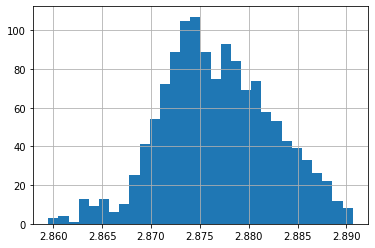

In [1170]:
pd.Series(train_target).hist(bins = 30)

`-` 히스토그램은 로그변환과 비슷해보임

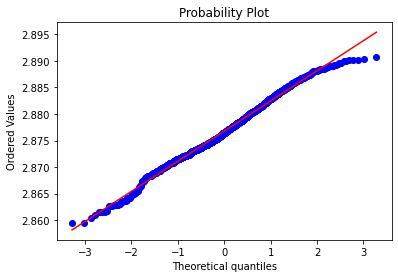

In [1171]:
_ = stats.probplot(pd.Series(train_target), plot = plt)

In [1172]:
test_stat, p_val = stats.shapiro(pd.Series(train_target))

In [1173]:
p_val, pd.Series(train_target).skew() ## p값과 왜도

(1.366531341773225e-05, 0.009664306847420746)

`-` 로그 변환보다 box-cox 변환이 더 우수한 변환으로 보인다

`-` box-cox 변환을 하자

`-` box-cox 변환의 단점이 train 셋에 의존한다는 것

`-` test 데이터에 train 셋의 box-cox 변환을 적용하면 오차가 꽤 생긴다(점수가 낮게 나왔음)

`-` 그러므로 로그 변환을 하자

## 모델링(선형 회귀)

`-` 간단하게 다중 선형 회귀를 해보자

### 변수 선택(뒤로부터 제거)

In [591]:
from sklearn.model_selection import train_test_split

In [595]:
df.shape ## 총 9개의 이상점을 제거함(더 있지만 일단은 냅둠)

(1341, 14)

In [775]:
dt = df.copy()

In [776]:
dt.drop(['Year_Built', 'Year_Remod_Add', 'Garage_Yr_Blt'], axis = 1, inplace = True)

`-` EDA를 했을 땐 연도가 의미있는 변수가 아니어서 모델링에 사용하지 않겠다

In [777]:
target = dt['target']  ## target
dt = dt.iloc[:, :-1]   ## target 제외한 데이터프레임

In [778]:
x_train, x_valid, y_train, y_valid = train_test_split(dt, target, test_size = 0.2, shuffle = True, random_state = 22)

## 표본크기가 1341로 커서 일단 교차검증은 하지 않음

In [779]:
y_train = np.log(y_train) ## 로그 변환

In [780]:
import statsmodels.formula.api as smf

In [781]:
tmp = pd.concat([x_train, y_train], axis = 1)

In [782]:
tmp.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,first_Flr_SF,Bsmt_Qual,Full_Bath,target
904,7,1536,3,2,532,3,1536,1536,3,2,12.273731
443,5,1588,2,2,480,2,768,1024,2,1,11.918391
22,7,1651,2,1,276,2,725,1035,2,2,12.055250
389,6,1152,2,2,412,2,912,1152,2,1,11.873742
681,8,1226,3,2,484,3,1226,1226,3,1,12.043554


`-` 선형회귀는 표준화를 하나 안하나 상관없어서 일단은 하지 않겠다

`-` 표준화를 하면 계수를 통해 중요성을 알 수 있긴 함

In [783]:
rst = smf.ols(formula = 'target~' + '+'.join(tmp.columns[:-1]), data = tmp).fit()
# rst.summary()

`-` Full_Bath 변수의 p값이 가장 유의하지 않으니 제거

In [784]:
tmp.drop('Full_Bath', axis = 1, inplace = True)

In [785]:
rst2 = smf.ols(formula = 'target~' + '+'.join(tmp.columns[:-1]), data = tmp).fit()
# rst2.summary()

`-` Exter_Qual 변수의 p값이 가장 유의하지 않으니 제거

In [786]:
tmp.drop('Exter_Qual', axis = 1, inplace = True)

In [787]:
rst3 = smf.ols(formula = 'target~' + '+'.join(tmp.columns[:-1]), data = tmp).fit()
# rst3.summary()

`-` Garage_Cars 변수의 p값이 가장 유의하지 않으니 제거

In [788]:
tmp.drop('Garage_Cars', axis = 1, inplace = True)

In [789]:
rst4 = smf.ols(formula = 'target~' + '+'.join(tmp.columns[:-1]), data = tmp).fit()
rst4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     895.5
Date:                Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                        23:02:55   Log-Likelihood:                 581.62
No. Observations:                1072   AIC:                            -1147.
Df Residuals:                    1064   BIC:                            -1107.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        10.4642      0.022    477.262      0.000      10.421      10.507
Overall_Qual      0.0811      0.006     14.438      0.000       0.070       0.092
Gr_Liv_Area       0.0003   1.23e-05     20.641      0.000       0.000       0.000
Garage_Area       0.0001   2.87e-05      5.025      0.000     8.8e-05       0.000
Kitchen_Qual      0.0669      0.009      7.325      0.000       0.049       0.085
Total_Bsmt_SF     0.0001   2.41e-05      5.363      0.000    8.21e-05       0.000
first_Flr_SF   7.197e-05   2.54e-05      2.830      0.005    2.21e-05       0.000
Bsmt_Qual         0.0931      0.009     10.801      0.000       0.076       0.110
==============================================================================
Omnibus:                       97.915   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.586
Skew:                          -0.639   Prob(JB):                     4.95e-36
Kurtosis:                       4.417   Cond. No.                     1.19e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

`-` 다중공선성이 있다는 메시지가 있는데 이는 표준화를 통해 해결할 수 있다(나중에 하자)

`-` 더 이상 유의하지 않은 피쳐는 없으므로 최종 모형은 rst4이다

### 잔차의 정규성 확인

<AxesSubplot:>

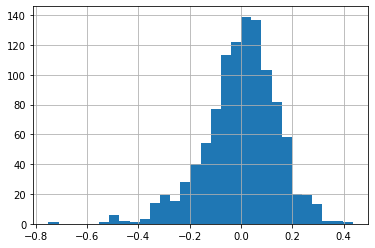

In [790]:
rst4.resid.hist(bins = 30)

Text(0.5, 1.0, 'fitted vs residual')

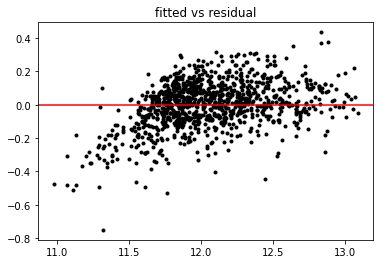

In [462]:
plt.plot(y_train, rst4.resid, '.k')
plt.axhline(0, 0.0, 1.0, color = 'red')
plt.title('fitted vs residual')

`-` 보면 문제가 있음(잔차가 정규분포를 안따름)

`-` 애초에 집값의 분포가 오른쪽으로 꼬리가 매우 긴 분포였고

`-` 로그 변환도 했지만 정규분포를 따르지 않았기에

`-` 이 정도는 그냥 넘어가자(사실 그러면 안 될 것 같지만...)

`-` 어떻게 해결할지 고민하자(독립 변수도 정규분포로 맞춰줘야 함)

In [508]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true - pred))
    score = mae / np.mean(np.abs(true))
    return score

In [532]:
## target을 로그 변환 했으므로 원래의 상태로 되돌리기 위해 exp를 취한다
NMAE(np.exp(y_train), np.exp(rst4.predict(x_train.drop(['Full_Bath', 'Exter_Qual', 'Garage_Cars'],  axis = 1))))

0.10197978889761221

`-` train 셋에 대한 NAME는 약 $0.1020$이다

In [528]:
## target을 로그 변환 했으므로 원래의 상태로 되돌리기 위해 exp를 취한다
NMAE(y_valid, np.exp(rst4.predict(x_valid.drop(['Full_Bath', 'Exter_Qual', 'Garage_Cars'],  axis = 1))))

0.08682483720006832

`-` valid 셋에 대한 NMAE는 약 $0.0868$이다

### test 예측

In [563]:
submission = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/sample_submission.csv')

`-` test 데이터에 대해 라벨인코딩을 해주자

In [520]:
for col in test.columns[test.dtypes == 'object']:
    test[col] = test[col].apply(lambda x: label_encoding(x))

In [534]:
test.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,first_Flr_SF,Bsmt_Qual,Full_Bath,Year_Built,Year_Remod_Add,Garage_Yr_Blt
0,9,1800,3,2,702,4,1800,1800,4,2,2007,2007,2007
1,6,1082,2,1,240,2,1082,1082,2,1,1948,1950,1948
2,6,1573,3,2,440,3,756,769,3,2,2000,2000,2000
3,6,2443,3,3,744,3,1158,1158,3,2,2004,2004,2004
4,5,1040,2,2,686,2,1040,1040,2,1,1968,1968,1991


`-` 모델을 만들자

In [560]:
model = smf.ols(formula = 'target~' + '+'.join(dt.drop(['Full_Bath', 'Exter_Qual', 'Garage_Cars'],  axis = 1).columns),
                data = pd.concat([dt.drop(['Full_Bath', 'Exter_Qual', 'Garage_Cars'],  axis = 1), np.log(target)], axis = 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     1132.
Date:                Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:55:38   Log-Likelihood:                 747.79
No. Observations:                1341   AIC:                            -1480.
Df Residuals:                    1333   BIC:                            -1438.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        10.4640      0.019    538.646      0.000      10.426      10.502
Overall_Qual      0.0826      0.005     16.741      0.000       0.073       0.092
Gr_Liv_Area       0.0002   1.08e-05     22.496      0.000       0.000       0.000
Garage_Area       0.0001   2.56e-05      5.791      0.000    9.79e-05       0.000
Kitchen_Qual      0.0681      0.008      8.460      0.000       0.052       0.084
Total_Bsmt_SF     0.0001   2.15e-05      6.744      0.000       0.000       0.000
first_Flr_SF   6.036e-05   2.21e-05      2.727      0.006    1.69e-05       0.000
Bsmt_Qual         0.0921      0.008     11.796      0.000       0.077       0.107
==============================================================================
Omnibus:                      155.305   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              300.434
Skew:                          -0.726   Prob(JB):                     5.78e-66
Kurtosis:                       4.808   Cond. No.                     1.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

`-` 이제 예측하자

In [578]:
## 위에서 구한 예측값을 그대로 넣어줌
submission['target'] = np.exp(model.predict(test))

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,target
0,1,348354.056444
1,2,133485.003772
2,3,170258.092173
3,4,239000.266354
4,5,128839.067660


In [582]:
## submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/submission1.csv', index = False)

`-` 반올림을 일의 자리에서 한 것과 하지 않은 것을 제출해봤는데 거의 비슷했다(한 것이 좋았음)

`-` 반올림 한 것의 점수는 $0.1135657683$

`-` train과 valid의 NMAE에 비해 더 높게 나왔는데 이는 잔차항을 살펴봤을 때 정규성을 띄지 않아

`-` 일반화 성능이 떨어진 것이 드러난 것이다

## 규제 선형 회귀(스케일링)

`-` 변수 선택에서 차이점이 있다

`-` 또한 회귀 계수의 중요성을 판단하고자 표준화도 하겠다

In [1288]:
dt = df2.copy()

`-` EDA를 했을 땐 연도가 의미있는 변수가 아니어서 모델링에 사용하지 않겠다

In [1289]:
target = dt['target']  ## target
dt = dt.iloc[:, :-1]   ## target 제외한 데이터프레임

In [1290]:
dt['gap_year_now_bulit'] = 2022 - dt['Year_Built']

In [1291]:
dt.drop(['Year_Built', 'Year_Remod_Add', 'Garage_Yr_Blt'], axis = 1, inplace = True)

`-` 이제 표준화를 해주자

`-` 그런데 독립 변수나 종속 변수나 이상점이 적지 않게 있었기에 로버스트 스케일링을 하겠다

`-` 일반적인 z-score 표준화도 하자(그리고 둘이 비교하자)

In [1292]:
from sklearn.preprocessing import RobustScaler, StandardScaler

In [1293]:
## 표준화, 로버스트 스케일러 생성
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

## 표준화
dt_scaled = standard_scaler.fit_transform(dt)
dt_scaled_df = pd.DataFrame(data = dt_scaled, columns = dt.columns)

## 로버스트 표준화
dt_robust = robust_scaler.fit_transform(dt)
dt_robust_df = pd.DataFrame(data = dt_robust, columns = dt.columns)

`-` Quality 관련 변수의 경우 Overall Quality가 대표성을 지니므로 Overall_Qual 변수만 사용하겠다(별로 였음)

In [1294]:
dt_scaled_df2 = dt_scaled_df.drop(['Exter_Qual', 'Kitchen_Qual', 'Bsmt_Qual'], axis = 1)
dt_robust_df2 = dt_robust_df.drop(['Exter_Qual', 'Kitchen_Qual', 'Bsmt_Qual'], axis = 1)

In [1295]:
dt_scaled_df.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,first_Flr_SF,Bsmt_Qual,Full_Bath,gap_year_now_bulit
0,2.937740,1.896548,2.802392,1.756527,2.485555,2.221963,3.532560,3.363828,2.034867,0.810179,-1.028350
1,0.618930,-0.328625,1.027544,0.209387,-0.180035,0.687586,0.739221,0.519605,2.034867,0.810179,-1.131557
2,-0.926943,-1.295719,-0.747305,-1.337752,-1.125204,-0.846792,-0.571500,-0.716538,-0.879913,-1.022368,0.210140
3,-0.926943,-0.709472,-0.747305,0.209387,0.404059,0.687586,-1.065706,-1.318200,-0.879913,-1.022368,2.515106
4,0.618930,0.967966,1.027544,1.756527,2.315637,0.687586,-0.136383,-0.371949,0.577477,0.810179,-1.097155


In [1296]:
dt_robust_df.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,first_Flr_SF,Bsmt_Qual,Full_Bath,gap_year_now_bulit
0,2.0,1.522053,2.0,1.0,2.245940,2.0,2.846272,2.587065,1.0,0.0,-0.600000
1,0.5,-0.145950,1.0,0.0,-0.083527,1.0,0.707455,0.517413,1.0,0.0,-0.666667
2,-0.5,-0.870890,0.0,-1.0,-0.909513,0.0,-0.296144,-0.382090,-1.0,-1.0,0.200000
3,-0.5,-0.431435,0.0,0.0,0.426914,1.0,-0.674550,-0.819900,-1.0,-1.0,1.688889
4,0.5,0.825982,1.0,1.0,2.097448,1.0,0.037018,-0.131343,0.0,0.0,-0.644444


### 스케일링

`-` z-점수 스케일링이나 로버스트 스케일링이나 비슷하다

`-` 계수를 통해 Overall_Qual과 Gr_Liv_Area이 매우 중요하며 그 다음은 Bsmt_Qual이다

`-` Kitchen_Qual과 Total_Bsmt_SF이 그 다음이며 나머지는 비슷하다

`-` 또한 Qual 관련 변수로 Overall Qual만 사용해봤는데 성능이 더 안좋게 나왔다(선형 회귀)

`-` 그래서 Qual 관련 변수를 추가했다

`-` 또한 현재 연도에서 완공 연도의 차이를 파생변수로 만들어 추가했다

`-` 사실 연도 변수는 포함시킬지 말지 고민했다

`-` 최근 연도일수록 집값이 평균적으로 높을텐데

`-` 이는 연도때문이라기 보다는 다른 변수에 의한 것이라 생각했기 때문이다

`-` 예컨대 과거에는 기술 등의 문제로 더 좋은 건물을 짓지 못했지만 최근에는 가능해진 상황

`-` 하지만 train 셋에 포함된 피쳐외의 특징을 연도 피쳐가 가지고 있을 수 있으니 포함하고 모델링 해보기로 했다

In [1297]:
x_train, x_valid, y_train, y_valid = train_test_split(dt_scaled_df, target.reset_index().drop('index', axis = 1), test_size = 0.2, shuffle = True, random_state = 22)

## 표본크기가 1341로 커서 일단 교차검증은 하지 않음

In [1298]:
y_train = np.log(y_train) ## 로그 변환

In [1299]:
import statsmodels.formula.api as smf

In [1300]:
tmp = pd.concat([x_train, y_train], axis = 1)

In [1301]:
tmp.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,first_Flr_SF,Bsmt_Qual,Full_Bath,gap_year_now_bulit,target
162,-0.926943,-1.034689,-0.747305,0.209387,1.312058,-0.846792,-0.147127,-0.382888,0.577477,-1.022368,-0.718727,11.845820
248,-1.699879,-1.349209,-0.747305,0.209387,1.211170,0.687586,-1.858047,-0.784908,-0.879913,-1.022368,0.038127,11.669929
982,-0.154006,-1.109575,-0.747305,-1.337752,-0.785368,-0.846792,-1.594828,-1.856962,-0.879913,-1.022368,0.038127,11.517913
258,-0.926943,-0.305089,1.027544,-1.337752,-1.125204,-0.846792,-0.184730,0.549688,-0.879913,-1.022368,0.760579,12.013095
261,1.391867,0.146364,1.027544,1.756527,1.720924,0.687586,1.335491,1.126737,0.577477,0.810179,-1.131557,12.354493


`-` 표준화 스케일링을 통해 변수의 중요도만 판단하자

In [1303]:
rst = smf.ols(formula = 'target~' + '+'.join(tmp.columns[:-1]), data = tmp).fit()
# rst.summary()

`-` Exter_Qual 변수 제거

In [1304]:
tmp.drop('Exter_Qual', axis = 1, inplace = True)

In [1306]:
rst2 = smf.ols(formula = 'target~' + '+'.join(tmp.columns[:-1]), data = tmp).fit()
# rst2.summary()

`-` Garage_Area 변수 제거

In [1307]:
tmp.drop('Garage_Area', axis = 1, inplace = True)

In [1308]:
rst3 = smf.ols(formula = 'target~' + '+'.join(tmp.columns[:-1]), data = tmp).fit()
rst3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     782.6
Date:                Tue, 25 Jan 2022   Prob (F-statistic):               0.00
Time:                        02:50:15   Log-Likelihood:                 670.67
No. Observations:                1064   AIC:                            -1321.
Df Residuals:                    1054   BIC:                            -1272.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.0597      0.004   3035.942      0.000      12.052      12.067
Overall_Qual           0.0967      0.007     14.488      0.000       0.084       0.110
Gr_Liv_Area            0.1247      0.006     20.613      0.000       0.113       0.137
Garage_Cars            0.0239      0.005      4.481      0.000       0.013       0.034
Kitchen_Qual           0.0375      0.005      6.835      0.000       0.027       0.048
Total_Bsmt_SF          0.0380      0.009      4.445      0.000       0.021       0.055
first_Flr_SF           0.0407      0.009      4.656      0.000       0.024       0.058
Bsmt_Qual              0.0337      0.007      5.114      0.000       0.021       0.047
Full_Bath             -0.0116      0.006     -2.024      0.043      -0.023      -0.000
gap_year_now_bulit    -0.0559      0.007     -8.545      0.000      -0.069      -0.043
==============================================================================
Omnibus:                       96.453   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.567
Skew:                          -0.542   Prob(JB):                     6.95e-47
Kurtosis:                       4.902   Cond. No.                         6.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 잔차의 정규성 확인

<AxesSubplot:>

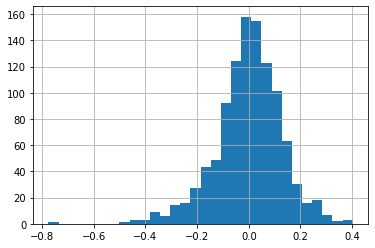

In [1318]:
rst3.resid.hist(bins = 30)

Text(0.5, 1.0, 'fitted vs residual')

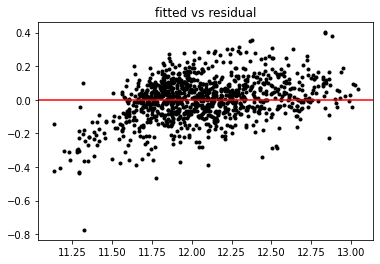

In [1319]:
plt.plot(y_train, rst3.resid, '.k')
plt.axhline(0, 0.0, 1.0, color = 'red')
plt.title('fitted vs residual')

`-` 잔차의 정규성 문제는 여전함(나중에 box-cox 변환을 해보자)

`-` box-cox 변환을 해봤는데 마찬가지었다

In [1320]:
## target을 로그 변환 했으므로 원래의 상태로 되돌리기 위해 exp를 취한다
NMAE(np.exp(y_train).to_numpy(), np.exp(rst3.predict(x_train)).to_numpy().reshape(-1,1))

0.09283755519722074

In [1321]:
## target을 로그 변환 했으므로 원래의 상태로 되돌리기 위해 exp를 취한다
NMAE(y_valid.to_numpy(), np.exp(rst3.predict(x_valid)).to_numpy().reshape(-1,1))

0.10145991179862908

### test 예측

`-` test 데이터에 대해 라벨인코딩을 해주자

In [1331]:
for col in test.columns[test.dtypes == 'object']:
    test[col] = test[col].apply(lambda x: label_encoding(x))

`-` test 데이터에 대해 표준화를 해주자

In [1332]:
test['gap_year_now_bulit'] = 2022 - test['Year_Built']

In [1334]:
test.drop(['Year_Built', 'Year_Remod_Add', 'Garage_Yr_Blt'], axis = 1, inplace = True)

In [1335]:
test.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,first_Flr_SF,Bsmt_Qual,Full_Bath,gap_year_now_bulit
0,9,1800,3,2,702,4,1800,1800,4,2,15
1,6,1082,2,1,240,2,1082,1082,2,1,74
2,6,1573,3,2,440,3,756,769,3,2,22
3,6,2443,3,3,744,3,1158,1158,3,2,18
4,5,1040,2,2,686,2,1040,1040,2,1,54


In [1337]:
## 표준화
test_scaled = standard_scaler.transform(test)
test_scaled_df = pd.DataFrame(data = test_scaled, columns = test.columns)

`-` 모델을 만들자

In [1362]:
model = smf.ols(formula = 'target~' + '+'.join(dt_scaled_df.drop(['Exter_Qual', 'Garage_Area'],  axis = 1).columns),
                data = pd.concat([dt_scaled_df.drop(['Exter_Qual', 'Garage_Area'],  axis = 1), np.log(target.reset_index().drop('index', axis = 1))], axis = 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     958.5
Date:                Tue, 25 Jan 2022   Prob (F-statistic):               0.00
Time:                        03:14:17   Log-Likelihood:                 834.69
No. Observations:                1330   AIC:                            -1649.
Df Residuals:                    1320   BIC:                            -1597.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.0593      0.004   3391.579      0.000      12.052      12.066
Overall_Qual           0.0952      0.006     15.636      0.000       0.083       0.107
Gr_Liv_Area            0.1303      0.005     23.730      0.000       0.119       0.141
Garage_Cars            0.0202      0.005      4.195      0.000       0.011       0.030
Kitchen_Qual           0.0385      0.005      7.821      0.000       0.029       0.048
Total_Bsmt_SF          0.0445      0.008      5.889      0.000       0.030       0.059
first_Flr_SF           0.0314      0.008      4.132      0.000       0.016       0.046
Bsmt_Qual              0.0316      0.006      5.336      0.000       0.020       0.043
Full_Bath             -0.0167      0.005     -3.253      0.001      -0.027      -0.007
gap_year_now_bulit    -0.0619      0.006    -10.604      0.000      -0.073      -0.050
==============================================================================
Omnibus:                      109.943   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              221.840
Skew:                          -0.532   Prob(JB):                     6.73e-49
Kurtosis:                       4.694   Cond. No.                         6.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

`-` 이제 예측하자

In [1369]:
## 위에서 구한 예측값을 그대로 넣어줌
submission['target'] = np.exp(model.predict(test_scaled_df))

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,target
0,1,328211.829183
1,2,132788.853750
2,3,177026.928932
3,4,254654.566501
4,5,130141.545456


In [1370]:
## submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/submission4.csv', index = False)

`-` 점수는 $0.11071$

`-` 문제점 : 잔차가 정규분포가 아니다(종속 변수를 정규분포로 맞추지 못함) $\to$ 어쩔 수 없음

`-` 다른 모형을 써보자